In [5]:
#import libraries
import sys, os
import pandas as pd
import numpy as np
#import deep learning libraries 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
#lets import the saved data back
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


# ----------------------------------------------- data setup -------------------------------------------------------------
#import the data file and get the information
df=pd.read_csv('fer2013.csv')
print(df.info())
print(df["Usage"].value_counts())
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

#declare the lists for the data seperation
x_train, y_train = [], []
x_valid, y_valid = [], []
x_test, y_test = [], []

#seperation of pixels for the train, valid, test sets
sum_train, sum_valid, sum_test = 0, 0, 0

for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
            #if sum_train == 10000:
                #continue
            
            x_train.append(np.array(val,'float32'))
            y_train.append(row['emotion'])
           
            sum_train = sum_train + 1 
            
        elif 'PublicTest' in row['Usage']:
            #if sum_valid == 1000:
                #continue
            
            x_valid.append(np.array(val,'float32'))
            y_valid.append(row['emotion'])
           
            sum_valid = sum_valid + 1
            
        elif 'PrivateTest' in row['Usage']:
            #if sum_test == 1000:
                #continue
            
            x_test.append(np.array(val,'float32'))
            y_test.append(row['emotion'])
           
            sum_test = sum_test + 1
            
    except:
        print(f"error occured at index :{index} and row:{row}")

#defining the parameters
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

# ----------------------------------------------preprocessing ----------------------------------------------------------
#converting the list to an array
x_train = np.array(x_train,'float32')
y_train = np.array(y_train,'float32')
x_valid = np.array(x_valid,'float32')
y_valid = np.array(y_valid,'float32')
x_test = np.array(x_test,'float32')
y_test = np.array(y_test,'float32')

#this is to do the following and this is an essential thing
"""
[0, 1, 2, 3] --> [[1. 0. 0. 0.]
                  [0. 1. 0. 0.]
                  [0. 0. 1. 0.]
                  [0. 0. 0. 1.]]
"""
y_train = np_utils.to_categorical(y_train, num_classes=num_labels)
y_valid = np_utils.to_categorical(y_valid, num_classes=num_labels)
#y_test = np_utils.to_categorical(y_test, num_classes=num_labels)

#normalization is done here x = [x-(miw)]/sigma
x_train -= np.mean(x_train, axis=0)
x_train /= np.std(x_train, axis=0)

x_valid -= np.mean(x_valid, axis=0)
x_valid /= np.std(x_valid, axis=0)

x_test -= np.mean(x_test, axis=0)
x_test /= np.std(x_test, axis=0)

#before there were [48x48] for one picture but here we create a matrix 
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
#---------------------------------------------creating the cnn -----------------------------------------------------------
#1st convolution layer

#for this cnn we use sequential model functional model is somewhat complex one
"""in this architecture i have given more focus on the regularization as in the test trial part it has been shown that
   cnn is overfitting"""
model = Sequential()
#block 1(not residual)
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
#block 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
#block 3
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
#block 4
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

model.summary()
"""
#Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

#Training the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_valid, y_valid),
          shuffle=True)        

#Saving the  model to  use it later on
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_22 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling

'\n#Compliling the model\nmodel.compile(loss=categorical_crossentropy,\n              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),\n              metrics=[\'accuracy\'])\n\n#Training the model\nmodel.fit(x_train, y_train,\n          batch_size=batch_size,\n          epochs=epochs,\n          verbose=2,\n          validation_data=(x_valid, y_valid),\n          shuffle=True)        \n\n#Saving the  model to  use it later on\nif os.path.isfile(\'fer.h5\') is False:\n    model.save_weights("fer.h5")\n'

3589/3589 [==============================] - 55s 15ms/step
Confusion matrix, without normalization
[[451   0  11   4  21   1   3]
 [  1  54   0   0   0   0   0]
 [ 17   1 464   6  23  10   7]
 [  5   0   3 852   8   6   5]
 [ 10   0  18   7 530   2  27]
 [  4   0  14   4   1 393   0]
 [ 10   1   5   9  23   1 577]]


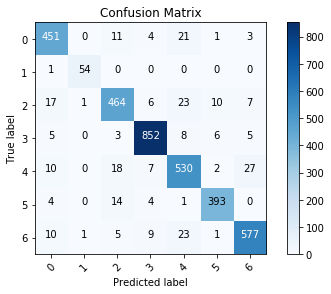

In [6]:
#----------------------------------------------loading the weights---------------------------------------------------------
model.load_weights('fer.h5')

#---------------------------------------------- getting the predictions ---------------------------------------------------
predictions = model.predict(x=x_test, verbose=1)
cm = confusion_matrix(y_true=y_test, y_pred=predictions.argmax(axis=1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     
cm_plot_labels = ['0','1','2','3','4','5','6']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')